# snATAC-seq - TF motif enrichment analysis

Blanca Pijuan-Sala

05 May 2019

In [12]:
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as pl
import scanpy.api as sc
import pandas as pd
import matplotlib.pyplot as plt
import episcanpy.api as epi
import anndata as ad
import numpy as np

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=100, color_map='viridis')  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()
#Set working directory
wd = '/path/to/directory/sample_pooled_preprocess_revision1/'
direc = wd
sc.settings.figdir = './plots/'
results_file="./write/20190416_snATACseq_embryo_revision01_doublets_cisTopic_50_100_filtered_final_TFchromVAR_allpeaks.h5ad"


scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.7 numpy==1.15.0 scipy==1.3.0 pandas==0.24.0 scikit-learn==0.20.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


## Read files

In [13]:
##====== Read counts ======##

filename_data = direc + '16_chromVAR/data/CHROMVAR_embryo_allPeaks_jointTogether_chromVAR_devScores_pwm_chromVar_sparse_raw_round4_peaksAll.mtx'
filename_barcodes = direc + '16_chromVAR/data/CHROMVAR_embryo_allPeaks_jointTogether_chromVAR_devZscores_colnames_cellNames_pwm_chromVar_raw_round4_peaksAll.tab'
filename_gene_names  = direc + '16_chromVAR/data/CHROMVAR_embryo_allPeaks_jointTogether_chromVAR_devScores_rownames_motifs_pwm_chromVar_raw_round4_peaksAll.tab'
#filename_clustersAll = wd + 'data/cellTypes_20180215.txt'
print('reading counts')
adata_all_cells = sc.read(filename_data, cache=True).transpose()
#adata_all_cells.X = adata_all_cells.X.astype(np.int64)
print('reading genes')
adata_all_cells.var_names = np.genfromtxt(filename_gene_names, dtype='str')
print('reading cells')
adata_all_cells.obs_names = np.genfromtxt(filename_barcodes, dtype='str')

reading counts
... reading from cache file cache/home-USSR-codex-pipeline-Data-Rebecca-Blanca-sample_pooled_preprocess_revision1-16_chromVAR-data-CHROMVAR_embryo_allPeaks_jointTogether_chromVAR_devScores_pwm_chromVar_sparse_raw_round4_peaksAll.h5ad
reading genes
reading cells


In [14]:
##====== Check number of total cells -rows- ======##

adata_all_cells.shape

(19453, 884)

In [15]:
##====== Read metadata file and set index to cell ======##

metadataFilename =direc + '14_visualisation/data/snATACseq_embryo_revision1_metadata_afterAllQC_passQC_UMAP_cluster.txt'
meta = pd.read_table(metadataFilename,delimiter="\t",header=0)
meta = meta.set_index(meta.barcode)


##======  Check columns in metadata ======##

meta.columns 

adata = adata_all_cells[np.array([i in np.array(meta['barcode']) for i in adata_all_cells.obs_names]),:]
adata.shape

##======  Filter metadata so that the cells correspond to those in the counts matrix ======##


metadata00 = pd.DataFrame(np.array(meta)[np.array([cell in adata.obs_names for cell in meta['barcode']]),:])
metadata00.columns = meta.columns 

metadata00 = metadata00.set_index(metadata00.barcode)
metadata00.shape
newClust = list()
for i in list(metadata00.loc[:,'final_clusters']):
    newClust.append("cluster_"+str(i))

adata.obs['final_clusters'] = list(newClust)


Trying to set attribute `.obs` of view, making a copy.


In [16]:
adata.shape

(19453, 884)

In [17]:
coord1 = list(np.array(metadata00.loc[:,'umap_X']))
coord2 = list(np.array(metadata00.loc[:,'umap_Y']))

adata.obsm["X_umap"] = np.array([coord1,coord2]).transpose()

## colour Palettes

In [18]:
##====== Create colour palette for gene expression profiles ======##

from matplotlib.colors import LinearSegmentedColormap
rmap = LinearSegmentedColormap.from_list(name='gene_cmap',
                                         colors=["#000000","#6495ED","#BFBFBF",
                                                  'thistle', 'red','darkred'])

cmap = LinearSegmentedColormap.from_list(name='gene_cmap',
                                         colors=["#BFBFBF","#6495ED","#000000"])

# Plot

In [ ]:
#adata = sc.read(results_file)


In [20]:
rmap = LinearSegmentedColormap.from_list(name='gene_cmap',
                                         colors=["#000000","#6495ED",
                                                 "#BFBFBF", "#BFBFBF",
                                                  'thistle', 'red','darkred'])

... storing 'final_clusters' as categorical


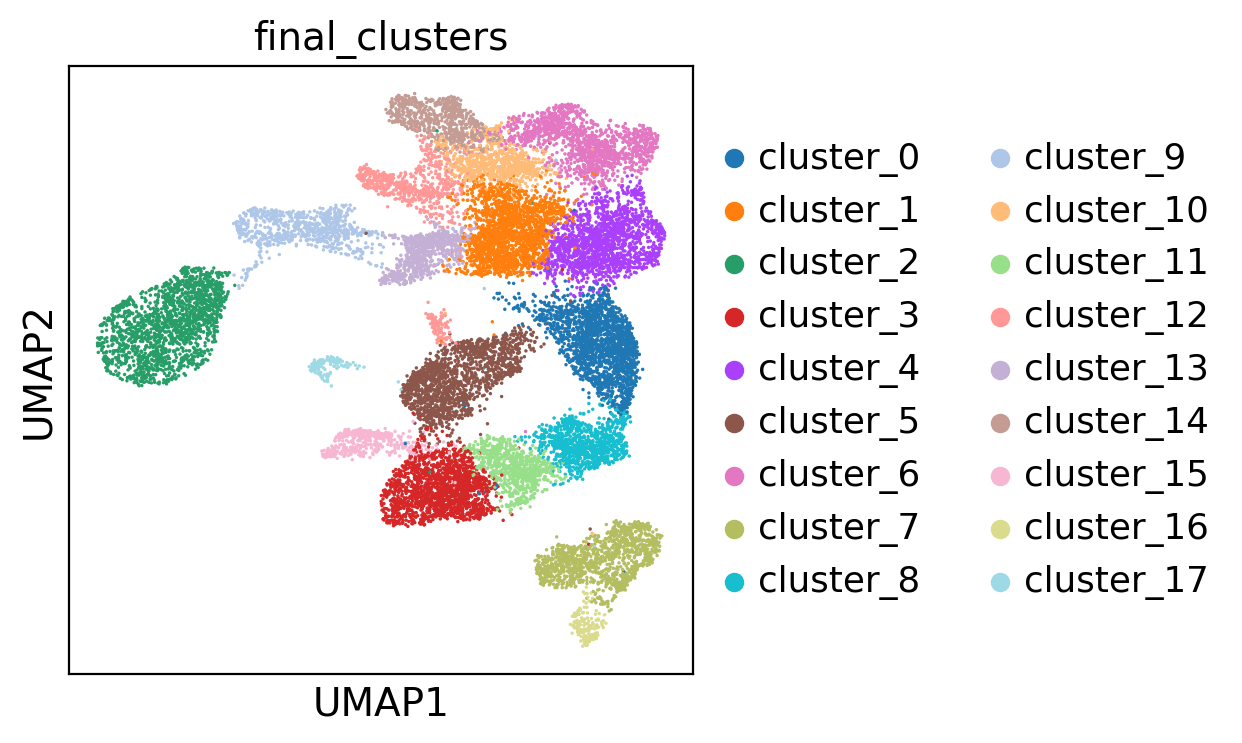

In [21]:
sc.pl.umap(adata,color="final_clusters"
              #save='embryo_together_tsne_256754peaks_clusterLouvain.pdf'
             )

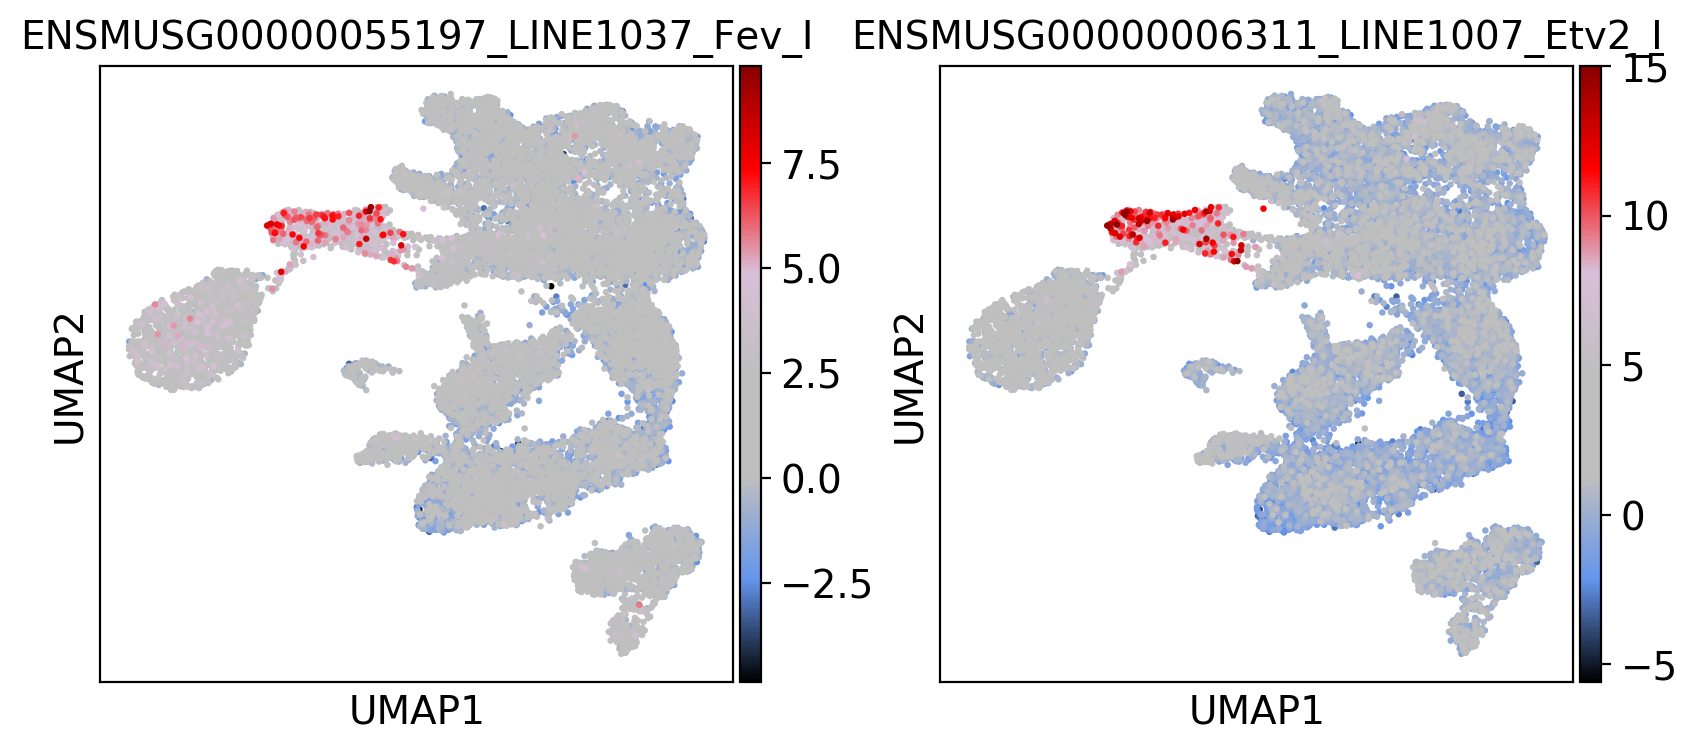

In [22]:
sc.pl.umap(adata,color=['ENSMUSG00000055197_LINE1037_Fev_I',"ENSMUSG00000006311_LINE1007_Etv2_I"],
              color_map=rmap,size=22,
              #save='embryo_together_tsne_256754peaks_clusterLouvain.pdf'
             )

# Rank genes with Wilcoxon test

In [49]:
sc.tl.rank_genes_groups(adata, groupby='final_clusters', test_type='wilcoxon',n_genes=884)


ranking genes


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:15)


In [ ]:
sc.write(results_file,adata)


In [50]:
genesMark = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
genesMarkscore = pd.DataFrame(adata.uns['rank_genes_groups']['scores'])
genesMarkFC = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'])
genesMarkpvals = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'])
genesMarkpvalsAdj = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'])


In [51]:
genesMark.to_csv(direc + '16_chromVAR/data/snATACseq_embryo_revision01_markerRegions_TFchromVar_allPeaks.csv', sep=',',header=True,index=False)
genesMarkscore.to_csv(direc + '16_chromVAR/data/snATACseq_embryo_revision01_markerRegions_scores_TFchromVar_allPeaks.csv', sep=',',header=True,index=False)
genesMarkFC.to_csv(direc + '16_chromVAR/data/snATACseq_embryo_revision01_markerRegions_logFC_TFchromVar_allPeaks.csv', sep=',',header=True,index=False)
genesMarkpvals.to_csv(direc + '16_chromVAR/data/snATACseq_embryo_revision01_markerRegions_pval_TFchromVar_allPeaks.csv', sep=',',header=True,index=False)
genesMarkpvalsAdj.to_csv(direc + '16_chromVAR/data/snATACseq_embryoTogether_markerRegions_pvalAdj_allPeaks.csv', sep=',',header=True,index=False)
